In [1]:
import pandas as pd
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import matplotlib.pyplot as plt
import json

/Users/praggathirajarao/Downloads/CS573_Final_Project/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [35]:
# Set up Spotify API credentials
client_id = 'f7b0a8e282ad4b2ca04bbc0e664f61d3'  # Replace with your Spotify client ID
client_secret = 'cfda8ebd6afe4c00a9cc7502fd8013cf'  # Replace with your Spotify client secret

# Authenticate with Spotify
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

# Function to extract song name from Spotify URL
def get_song_names_from_url(song_urls):
    song_names = []
    for i in range(len(song_urls)):
        track_id = song_urls[i].split("/")[-1].split("?")[0]  # Extract the track ID from the URL
        track_info = sp.track(track_id)  # Get track information
        song_name = track_info['name']  # Extract song name
        artist_name = track_info['artists'][0]['name']  # Extract artist name
        song_names.append(f"{song_name} by {artist_name}")
    return song_names

In [38]:
def create_user_song_label_df(json_file_path, moodify_csv_path):
    try:
        # Load the JSON file
        with open(json_file_path, 'r') as file:
            user_data = json.load(file)

        # Load the moodify_preprocessed.csv file
        moodify_df = pd.read_csv(moodify_csv_path)

        # Ensure 'song_uri' and 'label' columns exist in the moodify dataset
        if 'uri' not in moodify_df.columns or 'labels' not in moodify_df.columns:
            raise ValueError("The moodify_preprocessed.csv file must contain 'uri' and 'labels' columns.")

        # Prepare the result lists
        user_ids = sorted([int(user_id) for user_id in user_data.keys()])
        uri_lists = []
        song_name_lists = []
        label_lists = []

        # Iterate over the user data from JSON
        for user_id in user_ids:
            uri_list = user_data[str(user_id)]
            # Get song names for each URI
            song_names = get_song_names_from_url(uri_list)

            # Map each URI to its label using the moodify_preprocessed.csv dataset
            labels = []
            for uri in uri_list:
                # Match the URI to the label in moodify_preprocessed.csv
                label_row = moodify_df[moodify_df['uri'] == uri]
                if not label_row.empty:
                    label = label_row.iloc[0]['labels']
                else:
                    label = None  # If no label is found, set it to None
                labels.append(label)

            # Append data for the current user
            uri_lists.append(uri_list)
            song_name_lists.append(song_names)
            label_lists.append(labels)

        # Create the resulting DataFrame
        result_df = pd.DataFrame({
            'user_id': user_ids,
            'uri_list': uri_lists,
            'song_name_list': song_name_lists,
            'label_list': label_lists
        })

        return result_df

    except FileNotFoundError as e:
        print(f"File not found: {e}")
    except Exception as e:
        print(f"An error occurred: {e}")


**DO NOT RUN THE CELL BELOW**

In [ ]:
# Assuming 'user_playlists.json' is the JSON file and '../datasets/moodify_preprocessed.csv' is the CSV file
rnn_json_file_path = '../rnn/rnn_user_playlists.json'
llm_json_file_path = '../llm/llm_user_playlists.json'
vae_json_file_path = '../VAE/vae_recommendations/vae_recommendations.json'

moodify_csv_path = '../../datasets/moodify_preprocessed.csv'

rnn_df = create_user_song_label_df(rnn_json_file_path, moodify_csv_path)
print(rnn_df.head())

llm_df = create_user_song_label_df(llm_json_file_path, moodify_csv_path)
print(llm_df.head())

vae_df = create_user_song_label_df(vae_json_file_path, moodify_csv_path)
print(vae_df.head())

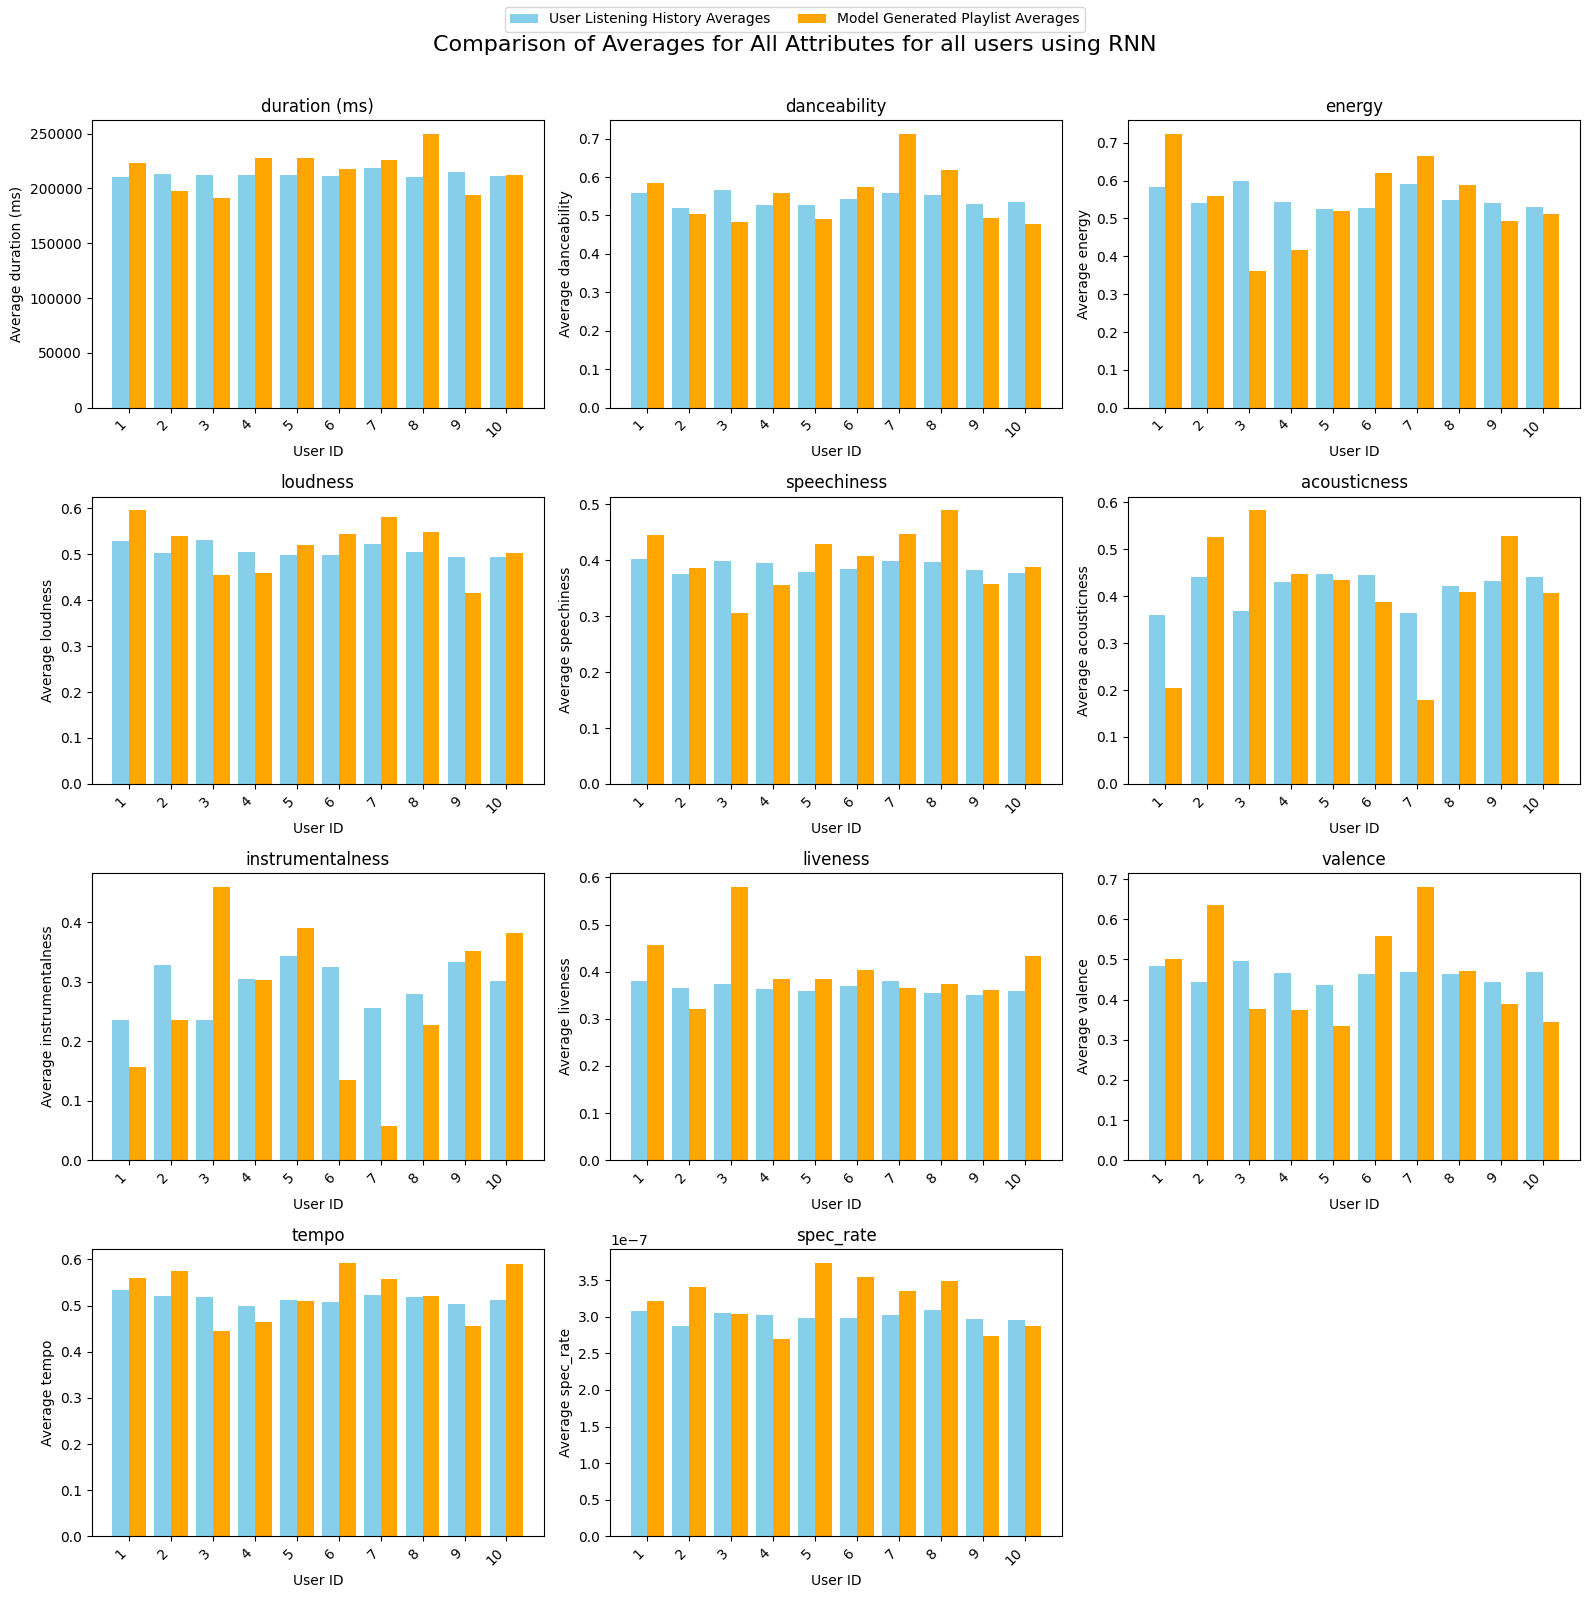

In [8]:
def rnn_plots(json_file_path, user_csv_folder_path, moodify_csv_path, title):
    # Load the playlist JSON file
    with open(json_file_path, 'r') as file:
        playlist_data = json.load(file)

    # Load the moodify_preprocessed.csv file
    moodify_df = pd.read_csv(moodify_csv_path)

    # Ensure moodify has the required columns
    required_columns = [
        'duration (ms)', 'danceability', 'energy', 'loudness',
        'speechiness', 'acousticness', 'instrumentalness',
        'liveness', 'valence', 'tempo', 'spec_rate', 'uri'
    ]
    if not all(col in moodify_df.columns for col in required_columns):
        raise ValueError(f"The moodify_preprocessed.csv file must contain the columns: {', '.join(required_columns)}")

    # Attributes to analyze
    attributes = [
        'duration (ms)', 'danceability', 'energy', 'loudness',
        'speechiness', 'acousticness', 'instrumentalness',
        'liveness', 'valence', 'tempo', 'spec_rate'
    ]

    # Initialize dictionaries to store averages
    user_averages = {attr: [] for attr in attributes}
    json_averages = {attr: [] for attr in attributes}
    user_ids = sorted([int(user_id) for user_id in playlist_data.keys()])  # Ensure user IDs are sorted

    # Iterate through each user in the JSON
    for user_id in user_ids:
        uris = playlist_data[str(user_id)]  # Access by string key
        user_csv_path = f"{user_csv_folder_path}/user{user_id}_1month_listening_history.csv"
        try:
            # Read the user's CSV file
            user_df = pd.read_csv(user_csv_path)

            # Filter the user's DataFrame to include only songs from the JSON playlist
            json_songs_df = moodify_df[moodify_df['uri'].isin(uris)]

            # If valid data exists, calculate averages
            if not user_df.empty:
                for attr in attributes:
                    user_averages[attr].append(user_df[attr].mean())
                    json_averages[attr].append(json_songs_df[attr].mean())

        except FileNotFoundError:
            print(f"CSV file for user {user_id} not found at {user_csv_path}. Skipping...")
            for attr in attributes:
                user_averages[attr].append(None)
                json_averages[attr].append(None)
        except Exception as e:
            print(f"Error processing data for user {user_id}: {e}")
            for attr in attributes:
                user_averages[attr].append(None)
                json_averages[attr].append(None)

    # Create a single figure with subplots for all attributes
    num_attributes = len(attributes)
    fig, axes = plt.subplots(nrows=(num_attributes + 2) // 3, ncols=3, figsize=(16, 16))  # Adjust size as needed
    axes = axes.flatten()

    for i, attr in enumerate(attributes):
        ax = axes[i]
        x = range(len(user_ids))  # x-axis positions for user IDs
        ax.bar(x, user_averages[attr], width=0.4, label='User CSV Averages', align='center', color='skyblue')
        ax.bar([p + 0.4 for p in x], json_averages[attr], width=0.4, label='JSON Playlist Averages', align='center', color='orange')

        # Add labels and title
        ax.set_title(attr)
        ax.set_xlabel("User ID")
        ax.set_ylabel(f"Average {attr}")
        ax.set_xticks([p + 0.2 for p in x])
        ax.set_xticklabels(user_ids, rotation=45, ha="right")

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Add a single legend for the entire figure
    fig.legend(["User Listening History Averages", "Model Generated Playlist Averages"], loc='upper center', ncol=2)
    fig.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the legend
    plt.suptitle(title, fontsize=16)
    plt.show()


json_file_path = '../rnn/rnn_user_playlists.json'
user_csv_folder_path = '../../datasets/user_month_datasets'
moodify_csv_path = '../../datasets/moodify_preprocessed.csv'
title = 'Comparison of Averages for All Attributes for all users using RNN'
rnn_plots(json_file_path, user_csv_folder_path, moodify_csv_path, title)


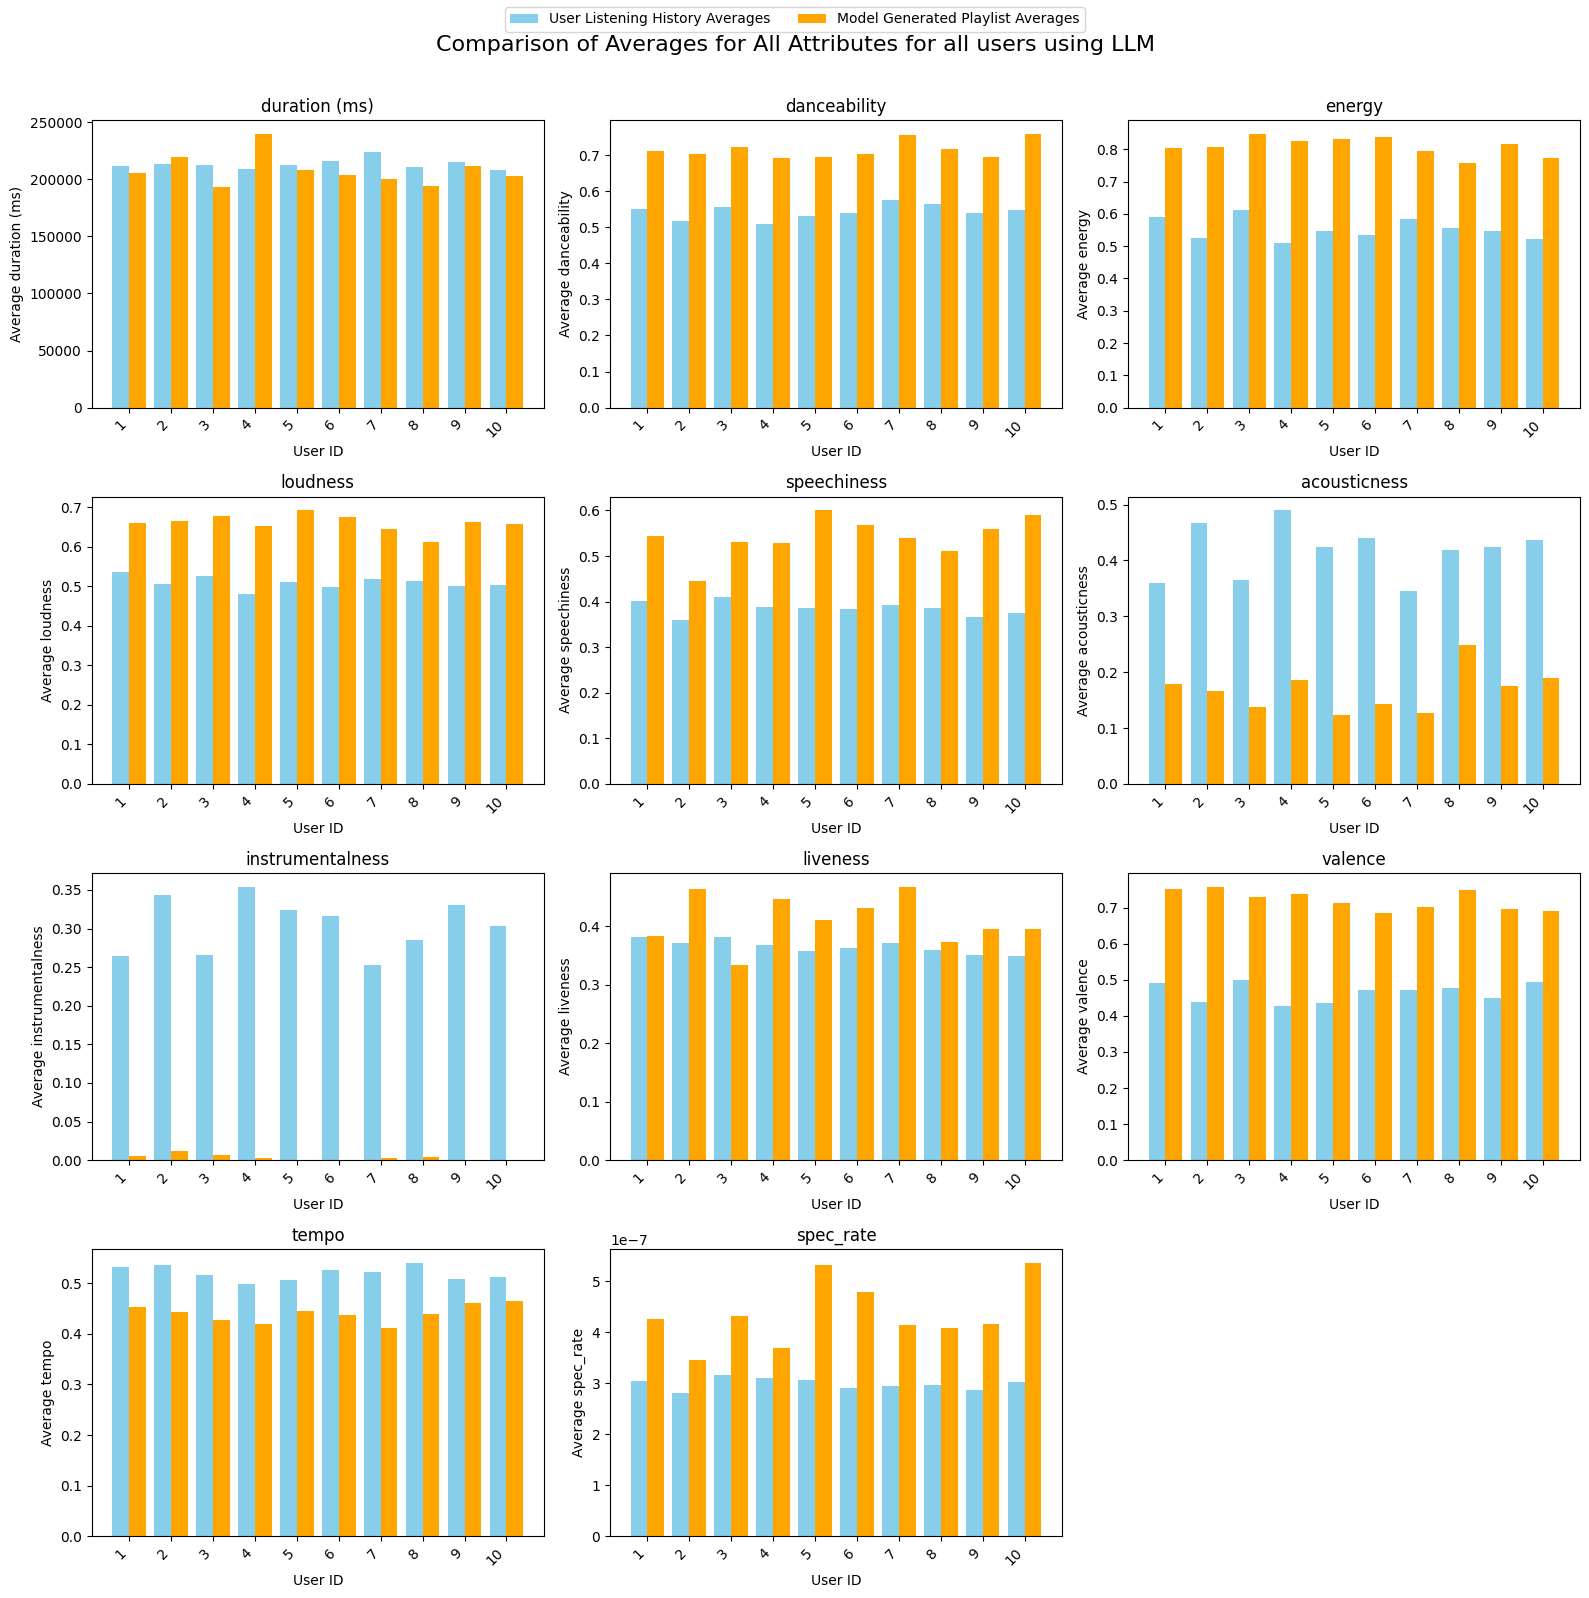

In [ ]:
# only plotting 10 users for plot readability 

def llm_plots(json_file_path, listening_history_path, moodify_csv_path, title):
    # Load the playlist JSON file
    with open(json_file_path, 'r') as file:
        playlist_data = json.load(file)

    # Load the listening history CSV file
    listening_history_df = pd.read_csv(listening_history_path)

    # Load the moodify_preprocessed.csv file
    moodify_df = pd.read_csv(moodify_csv_path)

    # Ensure required columns exist
    required_columns = [
        'duration (ms)', 'danceability', 'energy', 'loudness',
        'speechiness', 'acousticness', 'instrumentalness',
        'liveness', 'valence', 'tempo', 'spec_rate', 'uri'
    ]
    if not all(col in moodify_df.columns for col in required_columns):
        raise ValueError(f"The moodify_preprocessed.csv file must contain the columns: {', '.join(required_columns)}")
    if not all(col in listening_history_df.columns for col in required_columns + ['user_id']):
        raise ValueError(f"The listening history file must contain the columns: {', '.join(required_columns + ['user_id'])}")

    # Attributes to analyze
    attributes = [
        'duration (ms)', 'danceability', 'energy', 'loudness',
        'speechiness', 'acousticness', 'instrumentalness',
        'liveness', 'valence', 'tempo', 'spec_rate'
    ]

    # Initialize dictionaries to store averages
    user_averages = {attr: [] for attr in attributes}
    json_averages = {attr: [] for attr in attributes}
    user_ids = sorted([int(user_id) for user_id in playlist_data.keys()])  # Ensure user IDs are sorted
    user_ids = user_ids[:10]

    # Iterate through each user in the JSON
    for user_id in user_ids:
        uris = playlist_data[str(user_id)]  # Access by string key

        try:
            # Extract the user's listening history from the consolidated dataset
            user_history = listening_history_df[listening_history_df['user_id'] == user_id]

            # Filter the moodify_preprocessed.csv to include only the songs from the JSON playlist
            json_songs_df = moodify_df[moodify_df['uri'].isin(uris)]

            # If valid data exists, calculate averages
            if not user_history.empty:
                for attr in attributes:
                    user_averages[attr].append(user_history[attr].mean())
                    json_averages[attr].append(json_songs_df[attr].mean())

        except Exception as e:
            print(f"Error processing data for user {user_id}: {e}")
            for attr in attributes:
                user_averages[attr].append(None)
                json_averages[attr].append(None)

    # Create a single figure with subplots for all attributes
    num_attributes = len(attributes)
    fig, axes = plt.subplots(nrows=(num_attributes + 2) // 3, ncols=3, figsize=(16, 16))  # Adjust size as needed
    axes = axes.flatten()

    for i, attr in enumerate(attributes):
        ax = axes[i]
        x = range(len(user_ids))  # x-axis positions for user IDs
        ax.bar(x, user_averages[attr], width=0.4, label='User CSV Averages', align='center', color='skyblue')
        ax.bar([p + 0.4 for p in x], json_averages[attr], width=0.4, label='JSON Playlist Averages', align='center', color='orange')

        # Add labels and title
        ax.set_title(attr)
        ax.set_xlabel("User ID")
        ax.set_ylabel(f"Average {attr}")
        ax.set_xticks([p + 0.2 for p in x])
        ax.set_xticklabels(user_ids, rotation=45, ha="right")

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Add a single legend for the entire figure
    fig.legend(["User Listening History Averages", "Model Generated Playlist Averages"], loc='upper center', ncol=2)
    fig.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the legend
    plt.suptitle(title, fontsize=16)
    plt.show()

json_file_path = '../llm/llm_user_playlists.json'
listening_history_path = '../../datasets/seven_day_listening_history.csv'
moodify_csv_path = '../../datasets/moodify_preprocessed.csv'
title = 'Comparison of Averages for All Attributes for all users using LLM'
llm_plots(json_file_path, listening_history_path, moodify_csv_path, title)


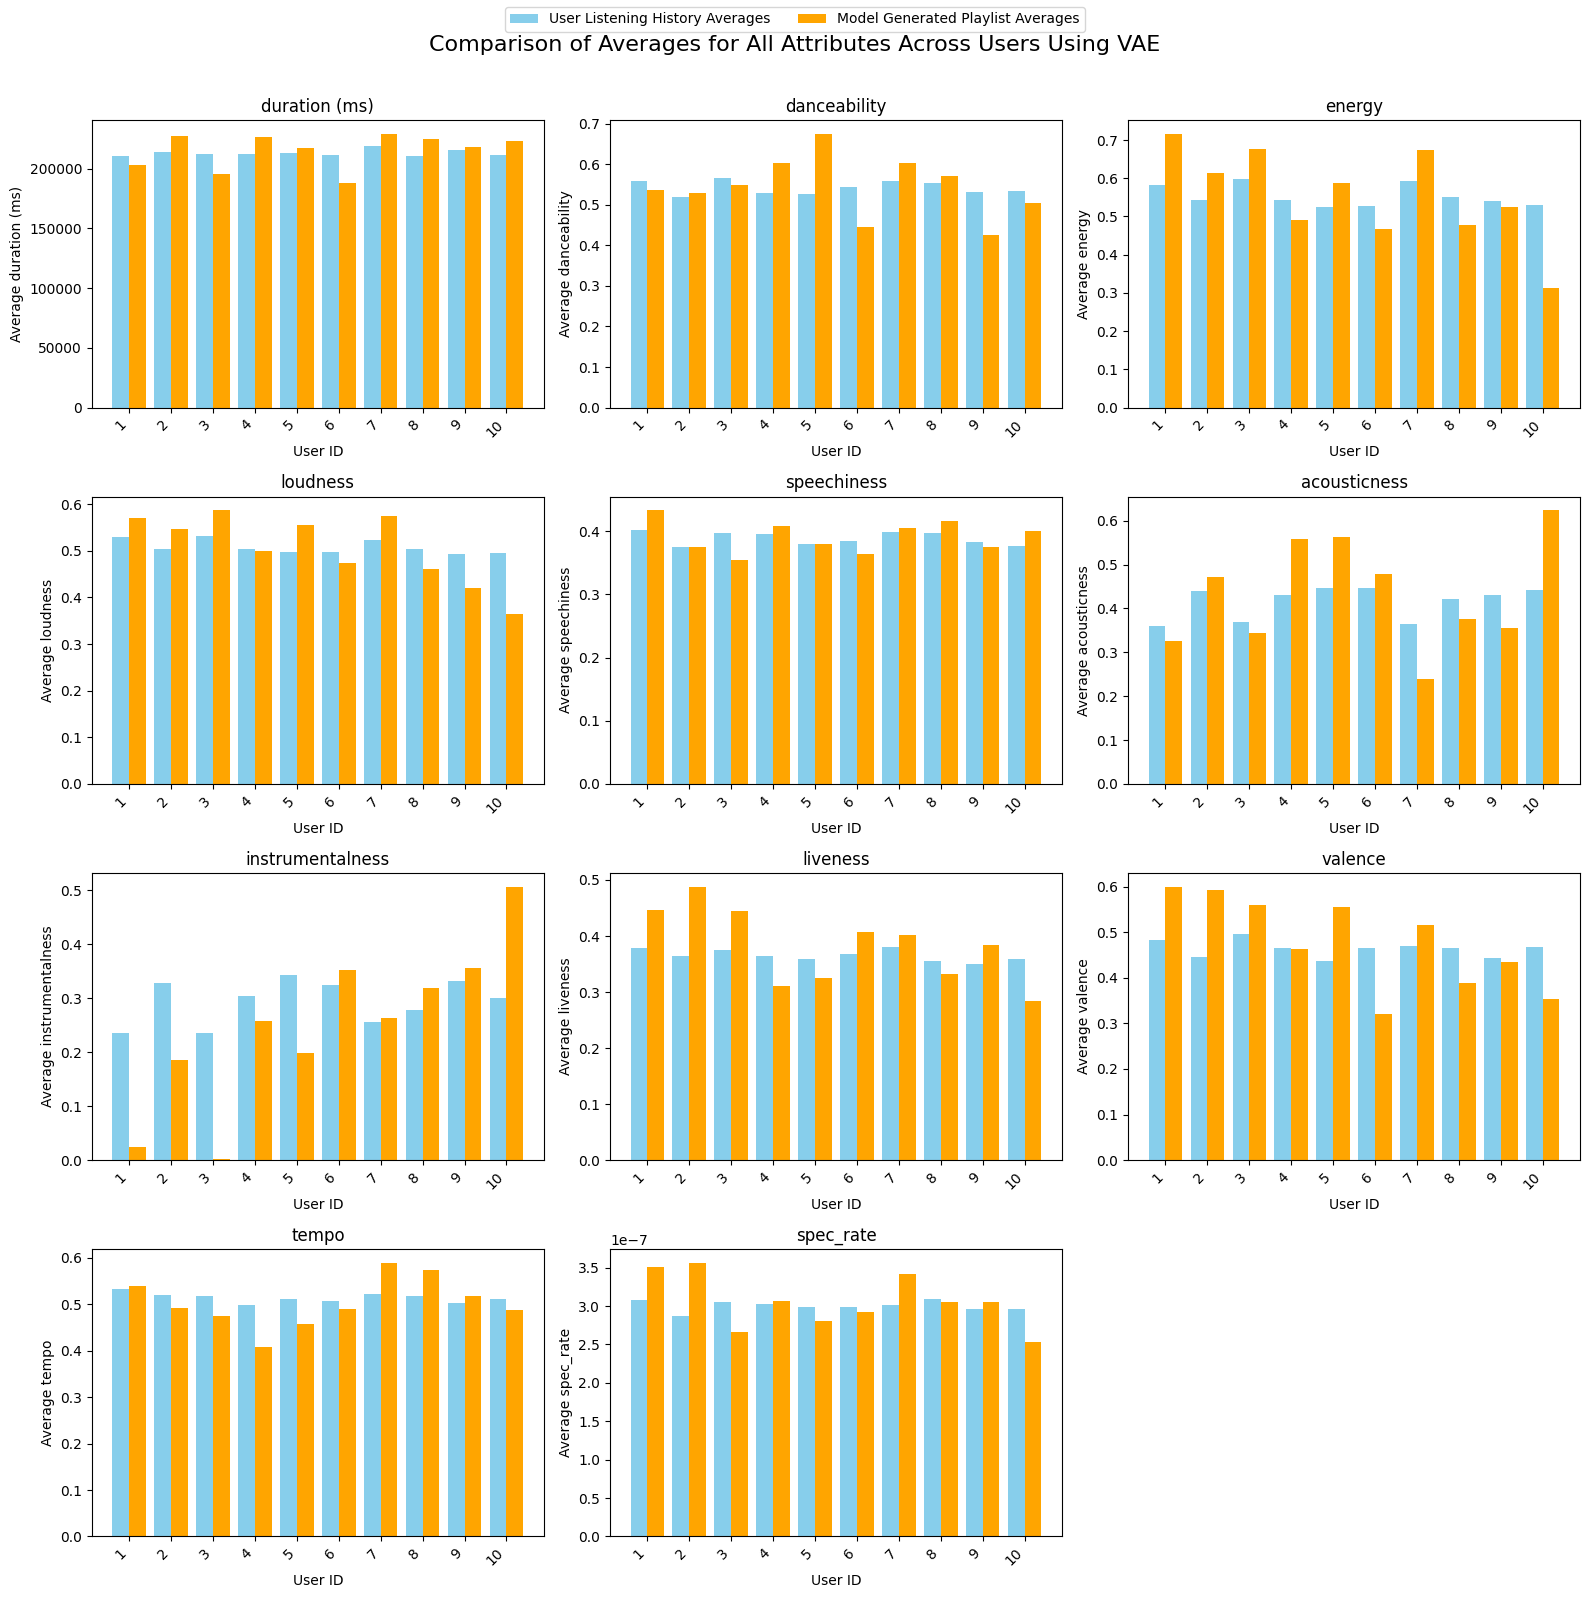

In [11]:
# VAE plots use same code as rnn plots
json_file_path = '../VAE/vae_recommendations/vae_recommendations.json'
user_csv_folder_path = '../../datasets/user_month_datasets'
moodify_csv_path = '../../datasets/moodify_preprocessed.csv'
title = 'Comparison of Averages for All Attributes Across Users Using VAE'
rnn_plots(json_file_path, user_csv_folder_path, moodify_csv_path, title)

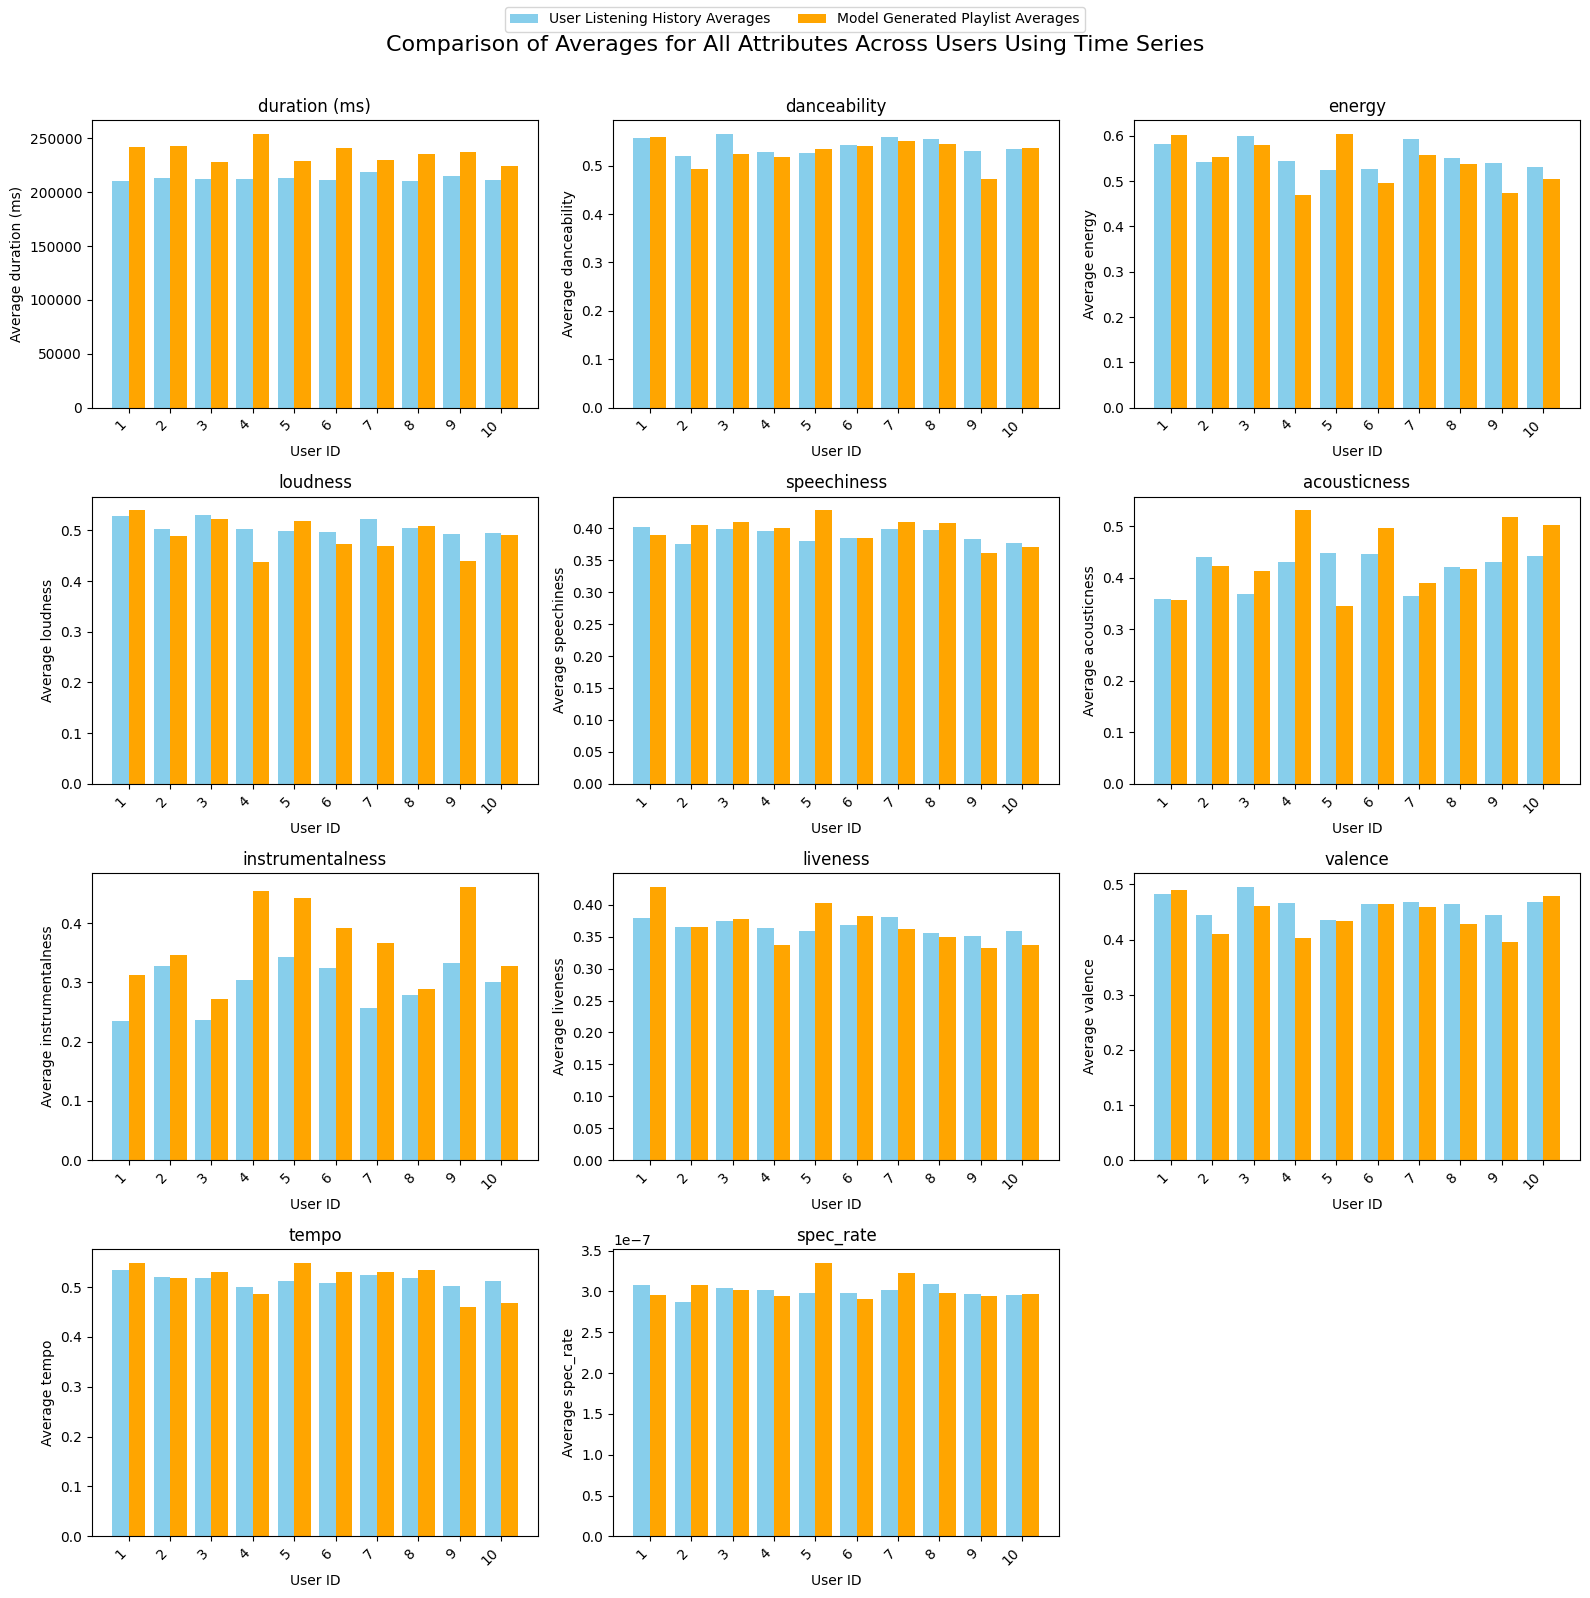

In [13]:
# VAE plots use same code as rnn plots
json_file_path = '../timeseries/generated_playlists.json'
user_csv_folder_path = '../../datasets/user_month_datasets'
moodify_csv_path = '../../datasets/moodify_preprocessed.csv'
title = 'Comparison of Averages for All Attributes Across Users Using Time Series'
rnn_plots(json_file_path, user_csv_folder_path, moodify_csv_path, title)

In [32]:

def calculate_differences(json_file_path, listening_history_path, moodify_csv_path):
    # Load the playlist JSON file
    with open(json_file_path, 'r') as file:
        playlist_data = json.load(file)

    # Load the listening history CSV file
    listening_history_df = pd.read_csv(listening_history_path)

    # Load the moodify_preprocessed.csv file
    moodify_df = pd.read_csv(moodify_csv_path)

    # Ensure required columns exist
    required_columns = [
        'duration (ms)', 'danceability', 'energy', 'loudness',
        'speechiness', 'acousticness', 'instrumentalness',
        'liveness', 'valence', 'tempo', 'spec_rate'
    ]
    if not all(col in moodify_df.columns for col in required_columns):
        raise ValueError(f"The moodify_preprocessed.csv file must contain the columns: {', '.join(required_columns)}")
    if not all(col in listening_history_df.columns for col in required_columns + ['user_id']):
        raise ValueError(f"The listening history file must contain the columns: {', '.join(required_columns + ['user_id'])}")

    # Attributes to analyze
    attributes = required_columns
    user_ids = sorted(listening_history_df['user_id'].unique())  # Get unique user IDs

    # Initialize list for differences
    differences = []

    # Iterate through each user
    for user_id in user_ids:
        # Extract user's listening history
        user_history = listening_history_df[listening_history_df['user_id'] == user_id]

        # If user has no listening history, skip
        if user_history.empty:
            continue

        # Extract model-generated playlist URIs for the user
        uris = playlist_data.get(str(user_id), [])
        if not uris:
            continue

        # Filter the moodify dataset for model-generated songs
        model_songs_df = moodify_df[moodify_df['uri'].isin(uris)]

        # Calculate averages for user and model
        user_averages = user_history[attributes].mean()
        model_averages = model_songs_df[attributes].mean()

        # Calculate differences and store results
        diff = model_averages - user_averages
        diff['user_id'] = user_id  # Add user_id for context
        differences.append(abs(diff))

    # Create a DataFrame from the differences
    differences_df = pd.DataFrame(differences)
    differences_df = differences_df.drop(columns=['user_id'], errors='ignore')

    return differences_df

json_file_path = '../llm/llm_user_playlists.json'
listening_history_path = '../../datasets/seven_day_listening_history.csv'
moodify_csv_path = '../../datasets/moodify_preprocessed.csv'

llm_differences_df = calculate_differences(json_file_path, listening_history_path, moodify_csv_path)
# Display the resulting DataFrame
print(llm_differences_df)


    duration (ms)  danceability    energy  loudness  speechiness  \
0     6279.075053      0.161905  0.213449  0.122404     0.144271   
1     6183.669874      0.186562  0.281701  0.161338     0.084263   
2    19813.870788      0.166634  0.235112  0.150216     0.120236   
3    30831.835412      0.181686  0.315791  0.172461     0.139309   
4     4456.717234      0.162764  0.285240  0.180985     0.214193   
..            ...           ...       ...       ...          ...   
95    8628.839177      0.154521  0.282956  0.172207     0.178522   
96    9836.292009      0.121095  0.177189  0.138445     0.188145   
97     827.738698      0.175000  0.292288  0.153383     0.167967   
98    2958.256038      0.184457  0.327730  0.171751     0.205601   
99    3382.646108      0.146010  0.197112  0.105014     0.123696   

    acousticness  instrumentalness  liveness   valence     tempo     spec_rate  
0       0.180095          0.258423  0.002102  0.261139  0.079407  1.210149e-07  
1       0.300672     

In [37]:
def calculate_rnn_differences_with_individual_files(json_file_path, user_csv_folder_path, moodify_csv_path):
    # Load the playlist JSON file
    with open(json_file_path, 'r') as file:
        playlist_data = json.load(file)

    # Load the moodify_preprocessed.csv file
    moodify_df = pd.read_csv(moodify_csv_path)

    # Ensure required columns exist
    required_columns = [
        'duration (ms)', 'danceability', 'energy', 'loudness',
        'speechiness', 'acousticness', 'instrumentalness',
        'liveness', 'valence', 'tempo', 'spec_rate', 'uri'
    ]
    if not all(col in moodify_df.columns for col in required_columns):
        raise ValueError(f"The moodify_preprocessed.csv file must contain the columns: {', '.join(required_columns)}")

    # Attributes to analyze
    attributes = [col for col in required_columns if col != 'uri']  # Exclude 'uri'
    differences = []  # List to store differences for each user

    # Iterate through each user in the JSON
    for user_id, uris in playlist_data.items():
        # Path to the user's 1-month listening history CSV file
        user_csv_path = f"{user_csv_folder_path}/user{user_id}_1month_listening_history.csv"

        try:
            # Load the user's 1-month listening history
            user_history_df = pd.read_csv(user_csv_path)

            # If user has no listening history, skip
            if user_history_df.empty:
                print(f"No data in {user_csv_path}. Skipping user {user_id}.")
                continue

            # Filter the moodify dataset for RNN-generated songs
            model_songs_df = moodify_df[moodify_df['uri'].isin(uris)].drop(columns=['uri'], errors='ignore')

            # Remove 'uri' column from user_history_df (if it exists)
            user_history_df = user_history_df.drop(columns=['uri'], errors='ignore')

            # Calculate averages for user and model
            user_averages = user_history_df[attributes].mean()
            model_averages = model_songs_df[attributes].mean()

            # Calculate differences and store results
            diff = abs(model_averages - user_averages)
            diff['user_id'] = user_id  # Add user_id for context
            differences.append(diff)

        except FileNotFoundError:
            print(f"File not found: {user_csv_path}. Skipping user {user_id}.")
        except Exception as e:
            print(f"Error processing data for user {user_id}: {e}")

    # Create a DataFrame from the differences
    differences_df = pd.DataFrame(differences)
    differences_df = differences_df.drop(columns=['user_id'], errors='ignore')

    return differences_df

json_file_path = '../rnn/rnn_user_playlists.json'  # Path to RNN JSON file
user_csv_folder_path = '../../datasets/user_month_datasets'  # Path to folder with user CSVs
moodify_csv_path = '../../datasets/moodify_preprocessed.csv'  # Path to moodify dataset

rnn_differences_df = calculate_rnn_differences_with_individual_files(json_file_path, user_csv_folder_path, moodify_csv_path)
print(rnn_differences_df)

json_file_path = '../VAE/vae_recommendations/vae_recommendations.json'  # Path to RNN JSON file
vae_differences_df = calculate_rnn_differences_with_individual_files(json_file_path, user_csv_folder_path, moodify_csv_path)
print(vae_differences_df)

json_file_path = '../timeseries/generated_playlists.json'  # Path to RNN JSON file
ts_differences_df = calculate_rnn_differences_with_individual_files(json_file_path, user_csv_folder_path, moodify_csv_path)
print(ts_differences_df)

   duration (ms)  danceability    energy  loudness  speechiness  acousticness  \
0   20226.462713      0.080920  0.238303  0.075816     0.092548      0.213977   
1   15336.606320      0.036389  0.003895  0.021734     0.050341      0.012057   
2   39235.209458      0.064900  0.039423  0.043738     0.092784      0.012499   
3    6577.544837      0.030629  0.092437  0.045512     0.023176      0.058640   
4    1323.712147      0.056526  0.017505  0.007966     0.010465      0.034245   
5    7067.297583      0.152924  0.072191  0.058593     0.048700      0.186076   
6   21542.737932      0.038195  0.047386  0.079154     0.025040      0.096154   
7   15405.054583      0.030636  0.128429  0.044236     0.038722      0.016429   
8   16226.102784      0.015225  0.016183  0.035234     0.009762      0.084810   
9   12404.164439      0.026660  0.140647  0.066378     0.042477      0.154566   

   instrumentalness  liveness   valence     tempo     spec_rate  
0          0.224045  0.206222  0.120515  0

In [38]:
def combine_model_differences(models_differences):
    combined_data = []

    for model_name, differences_df in models_differences.items():
        # Calculate the average difference for each attribute across all users
        attribute_averages = differences_df.mean(axis=0).to_dict()
        attribute_averages['model'] = model_name  # Add model name
        combined_data.append(attribute_averages)

    # Create a DataFrame with one row per model and columns for the average difference of each attribute
    combined_df = pd.DataFrame(combined_data)

    # Set the model column as the index for better clarity
    combined_df.set_index('model', inplace=True)

    return combined_df

models_differences = {
    'RNN': rnn_differences_df,
    'LLM': llm_differences_df,
    'VAE': vae_differences_df,
    'Time Series': ts_differences_df
}

# Combine the differences
combined_df = combine_model_differences(models_differences)
combined_df = combined_df.drop(columns=['duration (ms)'], errors='ignore')
# Display the resulting DataFrame
combined_df

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,spec_rate
model,,,,,,,,,,
RNN,0.053300,0.079640,0.047836,0.043401,0.086945,0.098103,0.052662,0.101396,0.043885,3.364763e-08
LLM,0.170828,0.229564,0.142512,0.166694,0.232296,0.264122,0.058379,0.256136,0.092163,1.456513e-07
VAE,0.056516,0.084727,0.052499,0.016099,0.079415,0.108114,0.053817,0.084490,0.040353,2.740633e-08
Time Series,0.016565,0.037243,0.025925,0.015742,0.049666,0.072377,0.020094,0.024686,0.021156,1.233827e-08


In [43]:
deviation_df = pd.DataFrame(combined_df, index=['RNN', 'LLM', 'VAE', 'Time Series'])

# Calculate the average deviation score for each model
deviation_df['average_deviation_score'] = deviation_df.sum(axis=1) / deviation_df.shape[1]

# Display the resulting DataFrame
deviation_df = deviation_df[['average_deviation_score']]
deviation_df

,average_deviation_score
RNN,0.060717
LLM,0.161269
VAE,0.057603
Time Series,0.028345


----------------------------------------------------------------

## Mood.fm Score Calculation

The **Mood.fm Score** is a metric designed to evaluate the alignment between a user's listening history and their recommended playlist based on their group-specific preferences. Each user is assigned to a group with predefined **attribute weights**. The score is calculated as a weighted sum of musical attributes for a given set of songs (listening history or playlist).

### Steps to Calculate Mood.fm Score

1. **Group Attribute Weights**:
   Each user group is defined by a dictionary of weights for musical attributes. For example:
   ```python
   user_groups = {
       1: {'attr_weights': {'danceability': 0.2, 'energy': 0.3, 'loudness': 0.3, 'speechiness': 0.4, 'acousticness': 0.8, 'instrumentalness': 0.6, 'liveness': 0.2, 'valence': 0.2, 'tempo': 0.4}},
       2: {'attr_weights': {'danceability': 0.7, 'energy': 0.5, 'loudness': 0.6, 'speechiness': 0.3, 'acousticness': 0.2, 'instrumentalness': 0.3, 'liveness': 0.4, 'valence': 0.7, 'tempo': 0.5}},
       ...
   }

2. **Normalize Musical Attributes**: 
Each song's musical attributes (e.g., danceability, energy, etc.) are normalized to a range between 0 and 1.

3. **Compute Weighted Sum**: 
For a given set of songs (e.g., listening history or playlist), the Mood.fm Score is calculated as:
<br>`Mood.fm Score = (1/N) * Σ (Σ (w_attr * v_attr_i))`
<br> Where: <br>
`N` is the total number of songs in the set.<br>
`w_attr` is the weight for the attribute (from the group weights).<br>
`v_attr_i` is the value of the attribute for song i.<br>

4. **Evaluate Score Alignment**:
 - User Score: Calculated based on the user's listening history.
 - Playlist Score: Calculated based on the recommended playlist.
 - Score Difference: The absolute difference between the user score and playlist score.

In [4]:
import numpy as np

user_groups = {
    1: {'label_weights': [0.6, 0.1, 0.1, 0.2], 'attr_weights': {'danceability': 0.2, 'energy': 0.3, 'loudness': 0.3, 'speechiness': 0.4, 'acousticness': 0.8, 'instrumentalness': 0.6, 'liveness': 0.2, 'valence': 0.2, 'tempo': 0.4}},
    2: {'label_weights': [0.1, 0.7, 0.4, 0.1], 'attr_weights': {'danceability': 0.7, 'energy': 0.5, 'loudness': 0.6, 'speechiness': 0.3, 'acousticness': 0.2, 'instrumentalness': 0.3, 'liveness': 0.4, 'valence': 0.7, 'tempo': 0.5}},
    3: {'label_weights': [0.1, 0.4, 0.8, 0.1], 'attr_weights': {'danceability': 0.6, 'energy': 0.8, 'loudness': 0.8, 'speechiness': 0.4, 'acousticness': 0.3, 'instrumentalness': 0.2, 'liveness': 0.7, 'valence': 0.5, 'tempo': 0.6}},
    4: {'label_weights': [0.2, 0.1, 0.1, 0.6], 'attr_weights': {'danceability': 0.3, 'energy': 0.2, 'loudness': 0.2, 'speechiness': 0.3, 'acousticness': 0.7, 'instrumentalness': 0.8, 'liveness': 0.3, 'valence': 0.4, 'tempo': 0.3}},
    5: {'label_weights': [0.3, 0.3, 0.2, 0.2], 'attr_weights': {'danceability': 0.5, 'energy': 0.5, 'loudness': 0.5, 'speechiness': 0.5, 'acousticness': 0.5, 'instrumentalness': 0.5, 'liveness': 0.5, 'valence': 0.5, 'tempo': 0.5}},
    6: {'label_weights': [0.1, 0.3, 0.7, 0.1], 'attr_weights': {'danceability': 0.6, 'energy': 0.9, 'loudness': 0.7, 'speechiness': 0.3, 'acousticness': 0.2, 'instrumentalness': 0.2, 'liveness': 0.6, 'valence': 0.6, 'tempo': 0.8}},
    7: {'label_weights': [0.2, 0.2, 0.1, 0.7], 'attr_weights': {'danceability': 0.2, 'energy': 0.3, 'loudness': 0.2, 'speechiness': 0.2, 'acousticness': 0.8, 'instrumentalness': 0.7, 'liveness': 0.3, 'valence': 0.3, 'tempo': 0.3}},
}

def compute_moodfm_score(data, group_no):
    attr_weights = user_groups[group_no]['attr_weights']
    weighted_sum = 0
    total_weight = sum(attr_weights.values())
    
    for attr, weight in attr_weights.items():
        if attr in data.columns:
            weighted_sum += data[attr].mean() * weight
    
    return weighted_sum / total_weight

In [5]:
import os
def evaluate_moodfm_scores(user_csv_folder_path, playlist_json_path):
    with open(playlist_json_path, 'r') as f:
        user_playlists = json.load(f)
    
    results = []
    
    for user_id, uris in user_playlists.items():
        user_csv_path = os.path.join(user_csv_folder_path, f"user{user_id}_1month_listening_history.csv")
        user_data = pd.read_csv(user_csv_path)
        
        playlist_data = user_data[user_data['uri'].isin(uris)]
        
        group_no = int(user_data['group_no'].iloc[0])
        
        user_score = compute_moodfm_score(user_data, group_no)
        playlist_score = compute_moodfm_score(playlist_data, group_no)

        results.append({
            'user_id': user_id,
            'group_no': group_no,
            'user_score': user_score,
            'playlist_score': playlist_score,
            'score_difference': abs(user_score - playlist_score)
        })
    
    return pd.DataFrame(results)

In [8]:
def plot_score_comparison(results_df, algorithm=None):
    if not algorithm:
        raise ValueError('algorithm must be specified')
    plt.figure(figsize=(10, 6))
    
    user_ids = results_df['user_id'].astype(int)
    user_scores = results_df['user_score']
    playlist_scores = results_df['playlist_score']
    
    plt.bar(user_ids - 0.2, user_scores, width=0.4, label='User Score', color='skyblue')
    plt.bar(user_ids + 0.2, playlist_scores, width=0.4, label='Playlist Score', color='orange')
    
    plt.xlabel('User ID')
    plt.ylabel('Score')
    plt.ylim((0, 0.6))
    plt.title(f'Comparison of Mood.fm Scores using {algorithm} for Playlist Generation')
    plt.legend()
    plt.xticks(user_ids)
    plt.show()

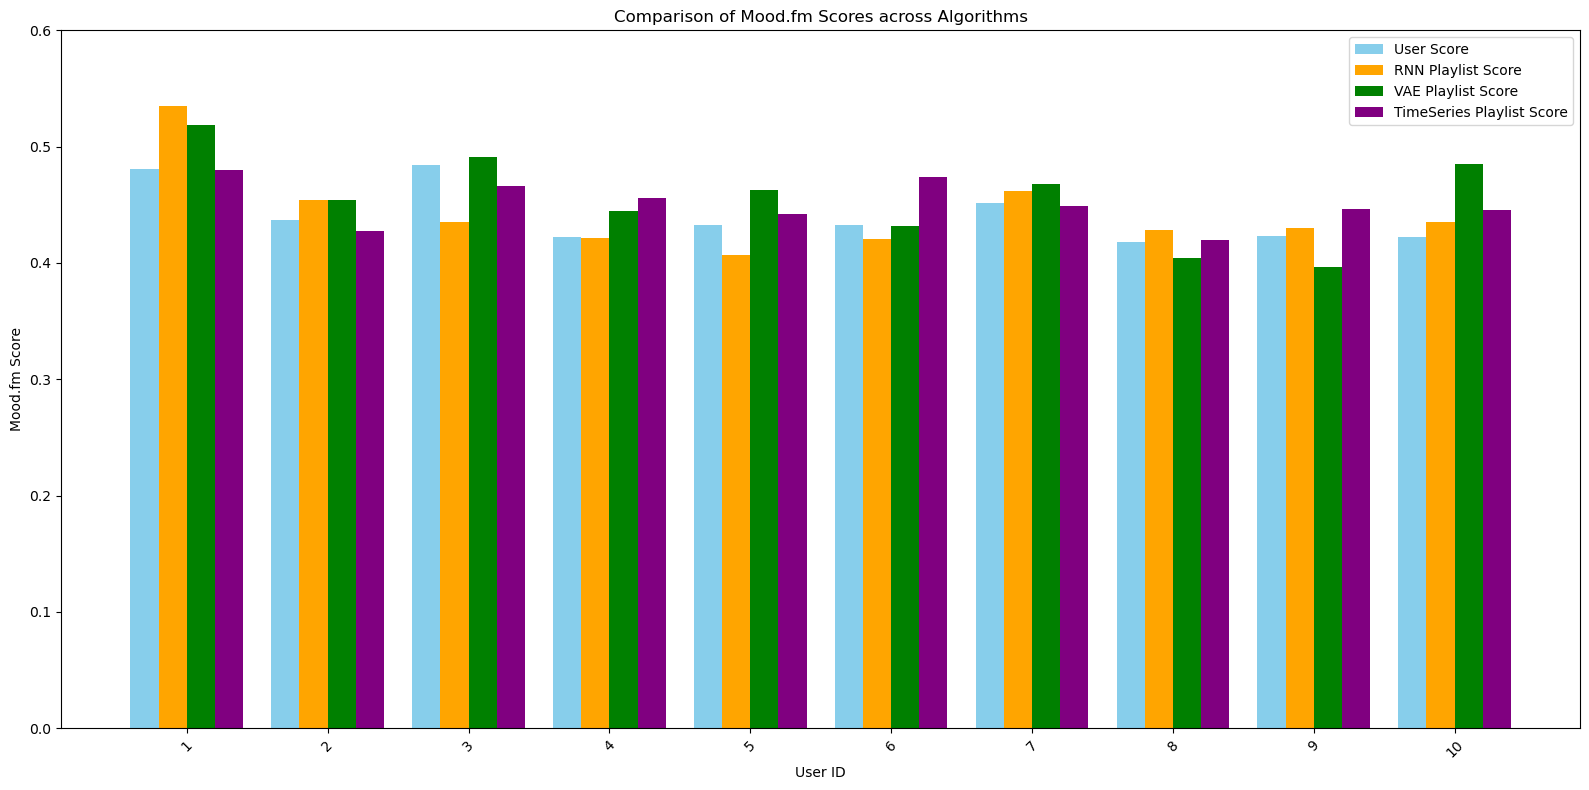

In [21]:
import matplotlib.pyplot as plt

def plot_multiple_score_comparisons(rnn_results, vae_results, timeseries_results):
    rnn_results['user_id'] = rnn_results['user_id'].astype(int)
    vae_results['user_id'] = vae_results['user_id'].astype(int)
    timeseries_results['user_id'] = timeseries_results['user_id'].astype(int)

    rnn_results = rnn_results.sort_values(by='user_id')
    vae_results = vae_results.sort_values(by='user_id')
    timeseries_results = timeseries_results.sort_values(by='user_id')

    user_ids = rnn_results['user_id'].astype(int)
    user_scores = rnn_results['user_score']
    rnn_scores = rnn_results['playlist_score']
    vae_scores = vae_results['playlist_score']
    timeseries_scores = timeseries_results['playlist_score']

    x = np.arange(len(user_ids))  # Position of each user
    bar_width = 0.2  # Width of each bar

    plt.figure(figsize=(16, 8))
    
    # Plot bars
    plt.bar(x - 1.5 * bar_width, user_scores, width=bar_width, label='User Score', color='skyblue')
    plt.bar(x - 0.5 * bar_width, rnn_scores, width=bar_width, label='RNN Playlist Score', color='orange')
    plt.bar(x + 0.5 * bar_width, vae_scores, width=bar_width, label='VAE Playlist Score', color='green')
    plt.bar(x + 1.5 * bar_width, timeseries_scores, width=bar_width, label='TimeSeries Playlist Score', color='purple')
    
    # Add labels, title, and legend
    plt.xlabel('User ID')
    plt.ylabel('Mood.fm Score')
    plt.title('Comparison of Mood.fm Scores across Algorithms')
    plt.xticks(x, user_ids, rotation=45)
    plt.ylim((0, 0.6))
    plt.legend()

    plt.tight_layout()
    plt.show()

rnn_results = evaluate_moodfm_scores(user_csv_folder_path,  "../rnn/rnn_user_playlists.json")
vae_results = evaluate_moodfm_scores(user_csv_folder_path,   "../VAE/vae_recommendations/vae_recommendations.json")
timeseries_results = evaluate_moodfm_scores(user_csv_folder_path,   "../timeseries/generated_playlists.json")
plot_multiple_score_comparisons(rnn_results, vae_results, timeseries_results)

In [39]:
def evaluate_llm_moodfm_scores(json_file_path, seven_day_history_path):
    with open(json_file_path, 'r') as file:
        playlist_data = json.load(file)

    user_history_df = pd.read_csv(seven_day_history_path)

    # Initialize results
    results = []

    for user_id, uris in playlist_data.items():
        user_id = int(user_id)

        user_history = user_history_df[user_history_df['user_id'] == user_id]
        if user_history.empty:
            print(f"User {user_id} has no listening history. Skipping...")
            continue

        group_no = user_history['group_no'].iloc[0]
        attr_weights = user_groups[group_no]['attr_weights']

        user_attributes = user_history[list(attr_weights.keys())]
        user_score = user_attributes.mean().dot(pd.Series(attr_weights))

        playlist_df = user_history_df[user_history_df['uri'].isin(uris)]
        if playlist_df.empty:
            print(f"No matching URIs found in the seven-day history for User {user_id}. Skipping...")
            continue

        playlist_attributes = playlist_df[list(attr_weights.keys())]
        playlist_score = playlist_attributes.mean().dot(pd.Series(attr_weights))

        score_difference = abs(user_score - playlist_score)

        results.append({
            'user_id': user_id,
            'group_no': group_no,
            'user_score': user_score,
            'playlist_score': playlist_score,
            'score_difference': score_difference
        })

    results_df = pd.DataFrame(results)
    return results_df

# LLM EVAL

In [91]:
def plot_group_averages(results_df):
    """
    Plot average scores and score differences for each user group.
    
    Parameters:
        results_df (pd.DataFrame): DataFrame containing evaluation results.
    """
    group_averages = results_df.groupby('group_no').mean()

    group_ids = group_averages.index
    user_scores = group_averages['user_score']
    playlist_scores = group_averages['playlist_score']
    score_differences = group_averages['score_difference']

    plt.figure(figsize=(10, 6))
    x = range(len(group_ids))
    plt.bar(x, user_scores, width=0.4, label='User Score', align='center', color='skyblue')
    plt.bar([i + 0.4 for i in x], playlist_scores, width=0.4, label='Playlist Score', align='center', color='orange')

    plt.xlabel('Group Number')
    plt.ylabel('Mood.fm Score')
    plt.title('Comparison of Average Mood.fm Scores by Group using LLM for Playlist Generation')
    plt.legend()
    plt.tight_layout()
    plt.show()

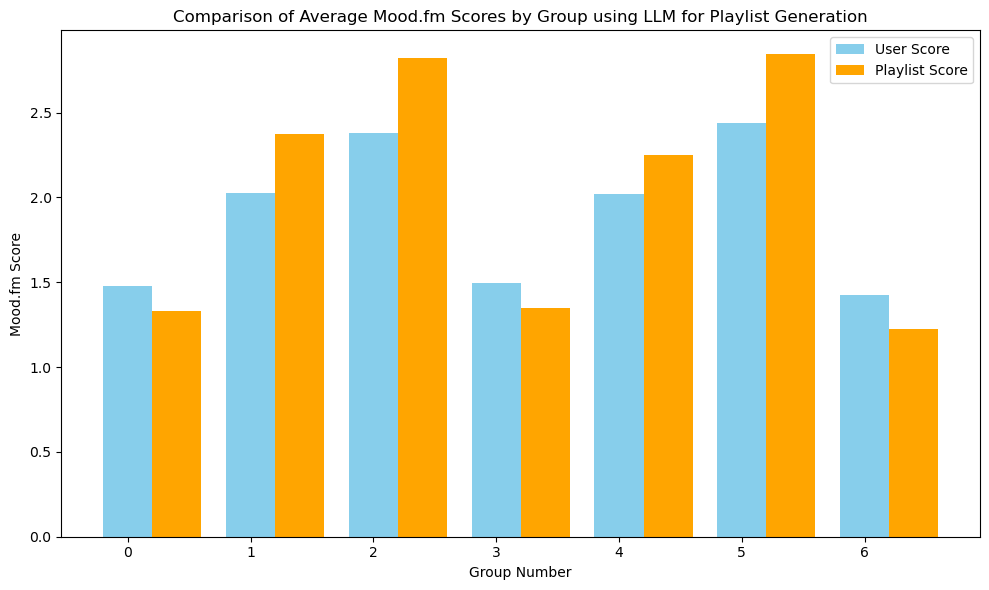

In [90]:
llm_json_file_path = '../llm/llm_user_playlists.json'
seven_day_history_path = '../../datasets/seven_day_listening_history.csv'

llm_results = evaluate_llm_moodfm_scores(llm_json_file_path, seven_day_history_path)
plot_group_averages(llm_results)

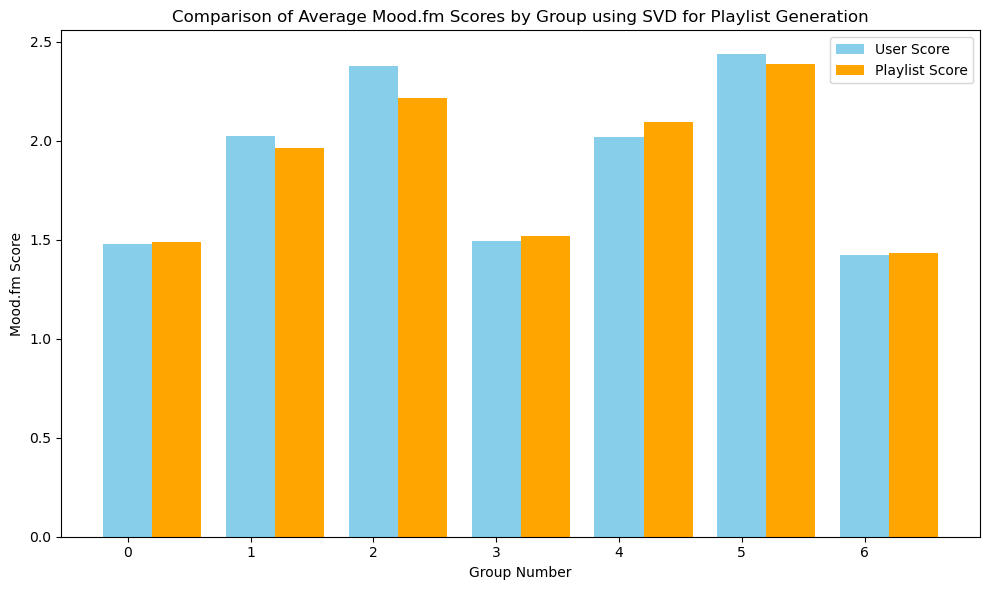

In [92]:
svd_results = evaluate_llm_moodfm_scores("../svd/svd_user_playlists.json", seven_day_history_path)
plot_group_averages(svd_results)

In [83]:
def create_moodfm_score_table(rnn_results, vae_results, timeseries_results, llm_results, svd_results):
    rnn_results['user_id'] = rnn_results['user_id'].astype(int)
    vae_results['user_id'] = vae_results['user_id'].astype(int)
    timeseries_results['user_id'] = timeseries_results['user_id'].astype(int)
    llm_results['user_id'] = llm_results['user_id'].astype(int)
    svd_results['user_id'] = svd_results['user_id'].astype(int)

    rnn_results = rnn_results.sort_values(by='user_id')
    vae_results = vae_results.sort_values(by='user_id')
    timeseries_results = timeseries_results.sort_values(by='user_id')
    llm_results = llm_results.sort_values(by='user_id')
    svd_results = svd_results.sort_values(by='user_id')

    table_rows = []

    for i, user_id in enumerate(rnn_results['user_id']):
        user_score = rnn_results.iloc[i]['user_score']

        table_rows.append({
            'user_id': user_id,
            'score_type': 'User',
            'score_value': user_score,
            'score_difference': 0.0
        })
        table_rows.append({
            'user_id': user_id,
            'score_type': 'RNN',
            'score_value': rnn_results.iloc[i]['playlist_score'],
            'score_difference': abs(user_score - rnn_results.iloc[i]['playlist_score'])
        })
        table_rows.append({
            'user_id': user_id,
            'score_type': 'VAE',
            'score_value': vae_results.iloc[i]['playlist_score'],
            'score_difference': abs(user_score - vae_results.iloc[i]['playlist_score'])
        })
        table_rows.append({
            'user_id': user_id,
            'score_type': 'TimeSeries',
            'score_value': timeseries_results.iloc[i]['playlist_score'],
            'score_difference': abs(user_score - timeseries_results.iloc[i]['playlist_score'])
        })

    score_table = pd.DataFrame(table_rows)

    average_differences = (
        score_table[score_table['score_type'] != 'User']
        .groupby('score_type')['score_difference']
        .mean()
        .reset_index()
    )
    
    llm_avg_difference = llm_results['score_difference'].mean()
    average_differences = pd.concat([
        average_differences,
        pd.DataFrame({'score_type': ['LLM'], 'score_difference': [llm_avg_difference]})
    ])

    svd_avg_difference = svd_results['score_difference'].mean()
    average_differences = pd.concat([
        average_differences,
        pd.DataFrame({'score_type': ['SVD'], 'score_difference': [svd_avg_difference]})
    ])
    
    average_differences.columns = ['Algorithm', 'Average Difference']
    
    return score_table, average_differences

score_table, average_differences = create_moodfm_score_table(
    rnn_results, vae_results, timeseries_results, llm_results, svd_results
)

In [84]:
score_table_nollm = score_table.set_index(["user_id", "score_type"]).unstack(1)
score_table_nollm

score_value                                score_difference  \
score_type         RNN TimeSeries      User       VAE              RNN   
user_id                                                                  
1             0.534774   0.479763  0.480688  0.518390         0.054086   
2             0.453723   0.427247  0.437344  0.453729         0.016380   
3             0.435086   0.466044  0.484366  0.490789         0.049280   
4             0.421457   0.455447  0.421953  0.444736         0.000496   
5             0.406814   0.442118  0.432628  0.462345         0.025814   
6             0.420781   0.473497  0.433052  0.431940         0.012271   
7             0.461624   0.449401  0.451730  0.467778         0.009895   
8             0.428229   0.419962  0.417880  0.404582         0.010350   
9             0.430381   0.445997  0.423576  0.396826         0.006805   
10            0.435333   0.445644  0.421972  0.485514         0.013361   

                                      
score_type TimeSeries User       VAE  
user_id                               
1            0.000925  0.0  0.037702  
2            0.010097  0.0  0.016385  
3            0.018322  0.0  0.006423  
4            0.033494  0.0  0.022783  
5            0.009490  0.0  0.029717  
6            0.040445  0.0  0.001112  
7            0.002328  0.0  0.016048  
8            0.002082  0.0  0.013298  
9            0.022422  0.0  0.026750  
10           0.023672  0.0  0.063542

In [85]:
average_differences

,Algorithm,Average Difference
0,RNN,0.019874
1,TimeSeries,0.016328
2,VAE,0.023376
0,LLM,0.273648
0,SVD,0.127488
